# Read in all traces
This includes both the time series from the CTD sensors and the injection meta-data.

Read sensor time series and concatenate the time series into one for each sensor

Load calibration script (also includes helper_functions.jl)

In [1]:
using NBInclude
@nbinclude("2_calibration.ipynb")
# set to true to get interactive plots, false for in-line plots
pygui(false);

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000812±9.9e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.00101±6.89e-5



Now load data-files from CTD sensors

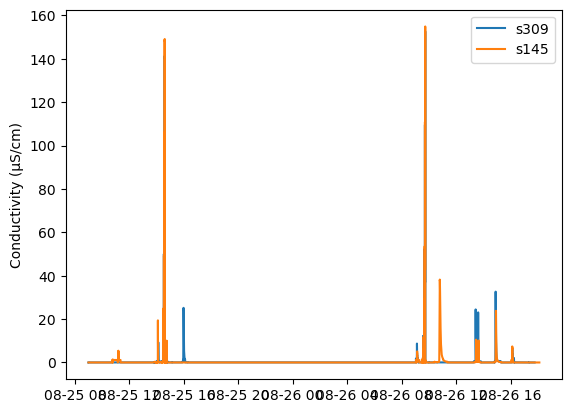

In [2]:
# for each sensor list all data-files
fls = Dict(:s145=>["../data/raw/example/205145-10mH2O_25_08_2021-09_00_00.CSV",
                   "../data/raw/example/205145-10mH2O_26_08_2021-08_30_00.CSV"],
           :s309=>["../data/raw/example/205309-100mH2O_25_08_2021-09_00_00.CSV",
                   "../data/raw/example/205309-100mH2O_26_08_2021-08_30_00.CSV"],
           # :s049=>[],
           # :s999
           )

sensor_readouts = Dict()
for sens in keys(fls)
    local out = read_Keller_DCX22_CTD(fls[sens][1])
    for fl = fls[sens][2:end]
        tmp = read_Keller_DCX22_CTD(fl)
        for (k,v) in tmp
            out[k] = [out[k]; tmp[k]]
        end
    end
    sensor_readouts[sens] = out
    # add calibration function (from 2_calibration.jl)
    sensor_readouts[sens][:cali_fn] = delta_cond2conc[sens]
end

fig = figure()
for sens in keys(sensor_readouts)
    plot(sensor_readouts[sens][:t], sensor_readouts[sens][:cond])
end
legend(keys(sensor_readouts))
ylabel("Conductivity (μS/cm)")
fig

Read tracer metadata.  This CSV-file needs to have the format

`Experiment No,Location,Date, Injection time, End time, Salt mass [g], 145, 049, 309`

(add more sensors to the back if needed)

In [3]:
metafile = "../data/raw/example/tracer_metadata.csv"
d,h = readdlm(metafile, ',', header=true)

(Any[1 "Lake" … 1 "x"; 2 "UpperGlacier" … 2 3; 4 "Lake" … "x" 1; 6 "UpperGlacier" … 2 1], AbstractString["Experiment No" "Location" … "049" "309"])

# Make the individual traces

┌ Warning: No data for sensor s049
└ @ Main.##284 string:23
┌ Warning: No data for sensor s049
└ @ Main.##284 string:23
┌ Warning: No data for sensor s049
└ @ Main.##284 string:23
┌ Warning: No data for sensor s049
└ @ Main.##284 string:23


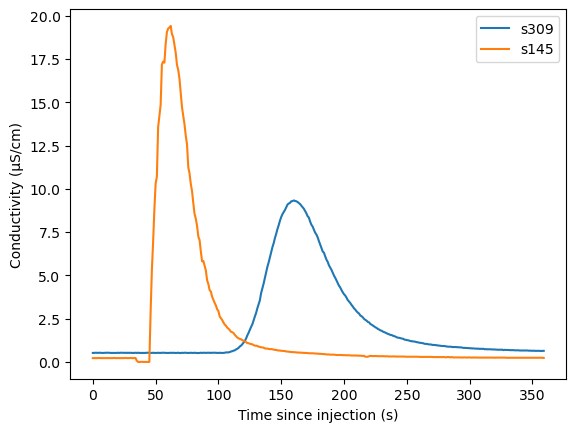

In [4]:
struct Trace
    nr
    location
    mass
    tinj
    tend
    sensors
    products
end

# Go through all meta-data lines and creates a Tracer-experiment for it
traces = []
for nr in 1:size(d,1)
    tinj = Dates.Date(d[nr,3], DateFormat("dd.mm.yyyy")) + Dates.Time(d[nr,4], "HH:MM")
    tend = Dates.Date(d[nr,3], DateFormat("dd.mm.yyyy")) + Dates.Time(d[nr,5], "HH:MM")

    # figure out which sensors/loggers were used
    local sensor_name = Symbol.("s".*h[7:end])
    sensors = Dict()
    for snr=1:length(sensor_name)
        sens = sensor_name[snr]
        if !haskey(sensor_readouts, sens)
            @warn("No data for sensor $sens")
            continue
        end
        if d[nr, snr+6]!="x"
            loc = d[nr, snr+6]
            sensors[loc] = cut_sensor_readout(sensor_readouts[sens], tinj, tend)
            sensors[loc][:sensor_name] = sens
        end
    end


    push!(traces,
          Trace(nr,
           d[nr,2],
           Float64(d[nr,6]),
           tinj,
           tend,
           sensors,
           Dict()
           ))
end

"""
    plot_trace(tr, field=:cond)

Function to plot a tracer experiment, possibly consiting of
several detectors.
"""
function plot_trace(tr, field=:cond)
    f = figure()
    for (k,sens) in tr.sensors
        plot(sens[:tsec], sens[field])
    end
    if isempty(tr.products)
        legend([v[:sensor_name] for (k,v) in tr.sensors])
    else
        legend(["$(v[:sensor_name]), loc=$k, Q=$(round(tr.products[k][:Q], sigdigits=2)) m³/s" for (k,v) in tr.sensors])
    end
    if field==:cond
        ylabel("Conductivity (μS/cm)")
    end
    xlabel("Time since injection (s)")
    return f
end

# Example
plot_trace(traces[2])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*